# facebook data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
%matplotlib inline
from scipy import optimize

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
    '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
    return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
# data cleaning: removing self-friendships
df_facebook_friends = df_facebook_friends[df_facebook_friends["user_b"] != df_facebook_friends["# user_a"]]
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())


facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


In [5]:
df_facebook_friends

,# user_a,user_b
0,0,512
1,0,263
2,0,525
3,0,285
4,0,543
...,...,...
6424,510,737
6425,510,763
6426,255,566
6427,255,605


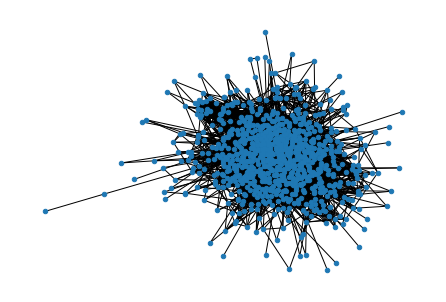

In [6]:
# create the graph
Gfacebook = nx.from_pandas_edgelist(df_facebook_friends, source="# user_a", target="user_b")

nx.draw(Gfacebook, node_size=20)

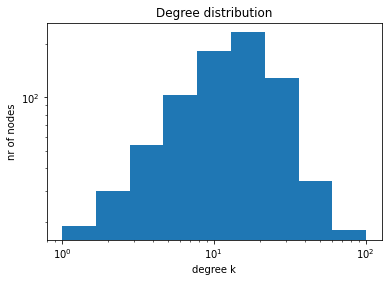

In [7]:
# degree distribution

degree_sequence = np.array(sorted((d for n, d in Gfacebook.degree()), reverse=True))
bin_edges = np.logspace(np.log10(degree_sequence.min()), np.log10(degree_sequence.max()), 10)
plt.hist(degree_sequence,bins=bin_edges)

plt.xscale('log')
plt.yscale('log')
plt.title('Degree distribution')
plt.xlabel('degree k')
plt.ylabel('nr of nodes')
plt.show()

La degree distribution è Poissoniana visto che non ha andamento di power law (non è lineare in log log)?\
Oppure abbiamo solo sbagliato il binning?

Complementary Cumulative Degree Distribution

When plotting the complementary cumulative degree distribution, $P_k \sim k^{ -(\gamma-1)}$ \
$\to$ linear fit $(y=mx+q)$ where $\gamma=1-m$

gamma = 1.0


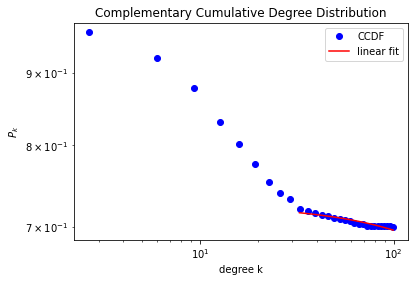

In [8]:
# CCDF
points, edg = np.histogram(degree_sequence,bins=30,density=True)

x = (edg[1:]+edg[:-1])*0.5
y = 1-np.cumsum(points)

# linear fit
def f(X,m,q):
    return X*m+q

popt, pcov = optimize.curve_fit(f,x[9:],y[9:])
gamma = 1-popt[0] 
print('gamma =',np.round(gamma,2))

# plot
plt.plot(x,y,'bo',label='CCDF')
plt.plot(x[9:],f(x[9:],popt[0],popt[1]),'r-',label='linear fit')
plt.title('Complementary Cumulative Degree Distribution')
plt.xlabel('degree k')
plt.ylabel(r'$P_k$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [9]:
# network parameters

N = Gfacebook.number_of_nodes()
L = Gfacebook.number_of_edges()
k_mean = np.mean(degree_sequence)
d_mean = nx.average_shortest_path_length(Gfacebook)
d_mean_est = np.log2(N)/np.log2(k_mean)
d_max = nx.diameter(Gfacebook)
print('N=',N,' L=',L,' k_mean=',int(k_mean),' d_mean=',np.round(d_mean,2),
      ' d_mean_est=',np.round(d_mean_est,2),' d_max=',d_max)

N= 800  L= 6418  k_mean= 16  d_mean= 2.98  d_mean_est= 2.41  d_max= 7


##### Centrality measures
The **degree centrality** for a node v is the fraction of nodes it is connected to.\
The **eigenvector centrality** computes the centrality for a node based on the centrality of its neighbors.\
The **closeness centrality** of a node u is the reciprocal of the average shortest path distance to u over all n-1 reachable nodes.\
The **betweenness centrality** of a node v is the sum of the fraction of all-pairs shortest paths that pass through v

In [11]:
import matplotlib.colors as mcolors
def func_to_plot(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    cent = np.fromiter(measures.values(), float)
    nodes.set_norm(mcolors.Normalize(vmin=cent.min(), vmax=cent.max()))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [12]:
# nodes positioned using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(Gfacebook)

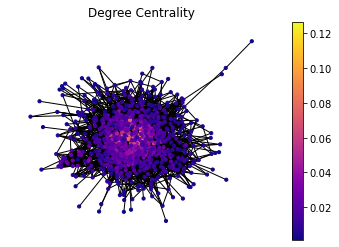

In [13]:
# degree centrality
DC = nx.degree_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, DC, 'Degree Centrality')

In [14]:
# top ten and last ten
DCtopten = sorted(DC, key=DC.get, reverse=True)[:10]
DCbottomten = sorted(DC, key=DC.get, reverse=False)[:10]

# print top ten
for i in DCtopten:
    print(i,DC[i])

485 0.12640801001251564
706 0.10763454317897372
13 0.09762202753441802
733 0.09261576971214018
838 0.09136420525657071
324 0.09011264080100126
472 0.09011264080100126
263 0.08886107634543179
221 0.08260325406758448
52 0.08135168961201503


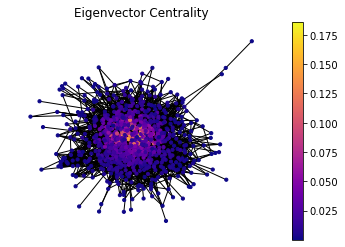

In [15]:
# eigenvector centrality
EC = nx.eigenvector_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, EC, 'Eigenvector Centrality')

In [16]:
# top ten and last ten
ECtopten = sorted(EC, key=EC.get, reverse=True)[:10]
ECbottomten = sorted(EC, key=EC.get, reverse=False)[:10]

# print top ten
for i in ECtopten:
    print(i,EC[i])

485 0.18573269594989783
706 0.18360327568417165
13 0.1567490856560137
472 0.1563559096458721
75 0.1462477987634866
838 0.14491258161309672
263 0.1449035991851265
324 0.14451811839339226
733 0.14151500475349188
221 0.14122597593180408


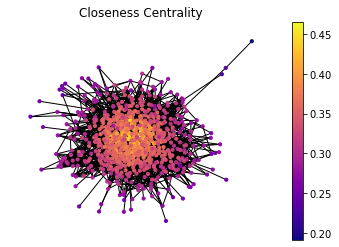

In [17]:
# closeness centrality
CC = nx.closeness_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, CC, 'Closeness Centrality')

In [18]:
# top ten and last ten
CCtopten = sorted(CC, key=CC.get, reverse=True)[:10]
CCbottomten = sorted(CC, key=CC.get, reverse=False)[:10]

# print top ten
for i in CCtopten:
    print(i,CC[i])

706 0.46480511925538104
13 0.4645348837209302
485 0.46131639722863743
472 0.45787965616045845
733 0.45683247570040025
263 0.45090293453724606
176 0.45090293453724606
324 0.4483726150392817
521 0.44611948632049137
52 0.444629938786867


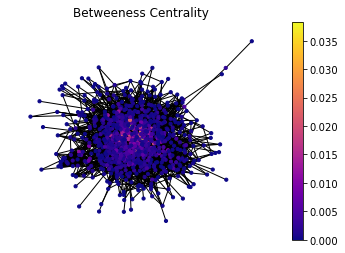

In [19]:
# betweeness centrality
BC = nx.betweenness_centrality(Gfacebook)
func_to_plot(Gfacebook, pos, BC, 'Betweeness Centrality')

In [20]:
# top ten and last ten
BCtopten = sorted(BC, key=BC.get, reverse=True)[:10]
BCbottomten = sorted(BC, key=BC.get, reverse=False)[:10]

# print top ten
for i in BCtopten:
    print(i,BC[i])

13 0.038225088235638915
485 0.03731986342529757
706 0.03554881413695769
324 0.02848765268019378
578 0.02688720421143541
733 0.026619980323726193
657 0.026222882193282487
263 0.023800845756492668
52 0.023154468888543573
81 0.022219172733915642


##### PageRank


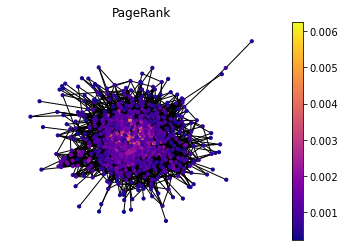

In [21]:
PR = nx.pagerank(Gfacebook, alpha=0.85)
func_to_plot(Gfacebook, pos, PR, 'PageRank')

In [22]:
# # top ten and last ten
PRtopten = sorted(PR, key=PR.get, reverse=True)[:10]
PRbottomten = sorted(PR, key=PR.get, reverse=False)[:10]

# print top ten
for i in PRtopten:
    print(i,PR[i])

485 0.006233567600646614
706 0.005375670332207295
13 0.005017475779677165
733 0.004692346222431574
324 0.004621690709077476
838 0.00451356571987314
472 0.004503275889159489
263 0.0044993159003908125
52 0.004295740119863544
300 0.004162609261910997


##### HITS

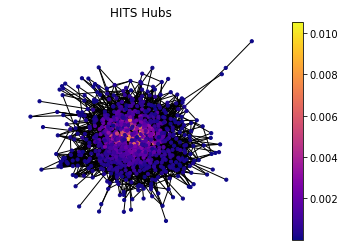

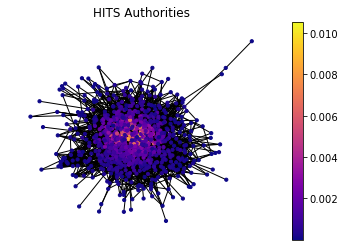

In [23]:
h,a = nx.hits(Gfacebook)
func_to_plot(Gfacebook, pos, h, 'HITS Hubs')
func_to_plot(Gfacebook, pos, a, 'HITS Authorities')

In [24]:
# top ten and last ten
atopten = sorted(a, key=a.get, reverse=True)[:10]
abottomten = sorted(a, key=a.get, reverse=False)[:10]

# print top ten
for i in atopten:
    print(i,a[i])

485 0.010518357166658472
706 0.010397994444022458
13 0.00887690002432889
472 0.008854596783058593
75 0.00828253874681466
838 0.008207005842200169
263 0.008206278819342838
324 0.008184411137316782
733 0.008014055115051677
221 0.007998163930818572


##### Comparison between centrality measures (top10 and last10)

In [108]:
# top 10
unique_topten = np.unique(sorted(DCtopten)+sorted(ECtopten)+sorted(CCtopten)+sorted(BCtopten)+sorted(PRtopten)+sorted(atopten))
print(unique_topten)

list_of_lists_top = [sorted(DCtopten),sorted(ECtopten),sorted(CCtopten),sorted(BCtopten),sorted(PRtopten),sorted(atopten)]

counts_top = []
for i in unique_topten:
    count = 0
    for l in list_of_lists_top:
        if i in l:
            count += 1
        else:
            pass
    counts_top.append(count)
print(counts_top)

[ 13  52  75  81 176 221 263 300 324 472 485 521 578 657 706 733 838]
[6, 4, 2, 1, 1, 3, 6, 1, 6, 5, 6, 1, 1, 1, 6, 6, 4]


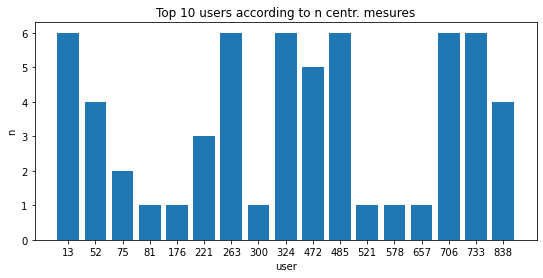

In [111]:
# histo
plt.figure(figsize=(9,4))
plt.bar(np.arange(len(unique_topten)),counts_top,tick_label=unique_topten)
plt.xlabel('user')
plt.ylabel('n')
plt.title('Top 10 users according to n centr. mesures')
plt.show()

$\to$ the 6 centrality measures analyzed totally agree on having on the top 10 the following users:


In [112]:
# users with score 6

In [27]:
# bottom 10
unique_bottomten = np.unique(sorted(DCbottomten)+sorted(ECbottomten)+sorted(CCbottomten)
                             +sorted(BCbottomten)+sorted(PRbottomten)+sorted(abottomten))
print(unique_bottomten)

list_of_lists_bottom = [sorted(DCbottomten),sorted(ECbottomten),sorted(CCbottomten),sorted(BCbottomten),sorted(PRbottomten),sorted(abottomten)]

counts_bottom = []
for i in unique_bottomten:
    count = 0
    for l in list_of_lists_bottom:
        if i in l:
            count += 1
        else:
            pass
    counts_bottom.append(count)
print(counts_bottom)

[ 45  77  98 125 150 264 361 420 434 459 495 516 548 565 592 629 680 697
 704 705 710 730 765 767 769 783 810 825]
[3, 2, 3, 1, 1, 2, 1, 5, 2, 1, 3, 5, 2, 3, 3, 2, 1, 2, 3, 3, 1, 1, 3, 2, 1, 2, 1, 1]


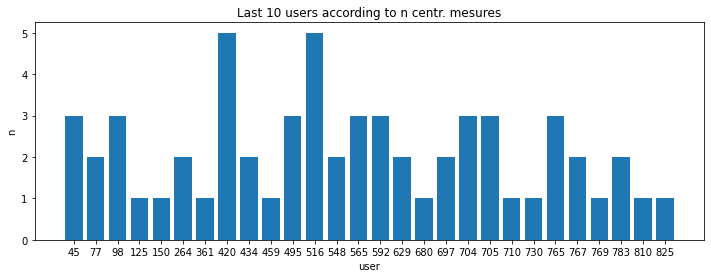

In [116]:
# histo
plt.figure(figsize=(12,4))
plt.bar(np.arange(len(unique_bottomten)),counts_bottom,tick_label=unique_bottomten)
plt.xlabel('user')
plt.ylabel('n')
plt.title('Last 10 users according to n centr. mesures')
plt.show()

Only users 420 and 516 are present in the last 10 for each of the 6 centrality measures considered. The majority is n=3, are they the same measures? (To see which measures are more similar)

##### Community detection
For the community detection task we use the Girvan-Newman algorithm. It relies on the iterative elimination of edges that have the highest number of shortest paths between nodes passing through them. By removing edges from the graph one-by-one, the network breaks down into smaller pieces, so-called communities.


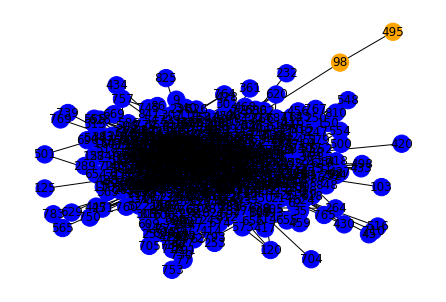

In [63]:
from networkx.algorithms.community.centrality import girvan_newman

communities = girvan_newman(Gfacebook)

node_groups = []
for com in next(communities):
    node_groups.append(list(com))

#print(node_groups)

color_map = []
for node in Gfacebook:
    
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('orange')  
nx.draw(Gfacebook, node_color=color_map, with_labels=True)
plt.show()

As we can see from the plot, according to the Girvan-Newman algorithm we have only two distinct communities: one composed of the majority of the nodes, the other with the two nodes corresponding to the user nr 98 and 495.

**!! Investigare se anche dagli altri dataset si ritrova questa community separata.**

[517, 8, 655, 527, 150, 62, 26, 57, 160, 802, 419, 164, 163, 38, 295, 680, 296, 35, 811, 557, 559, 304, 305, 692, 566, 184, 313, 314, 571, 60, 573, 318, 702, 64, 705, 697, 835, 579, 453, 582, 839, 584, 577, 204, 463, 592, 339, 596, 340, 85, 601, 91, 247, 347, 605, 120, 604, 609, 606, 483, 102, 232, 745, 106, 364, 494, 369, 116, 245, 758, 631, 500, 377, 757, 379, 255]


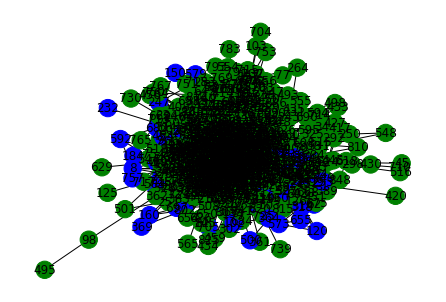

In [62]:
# asyn_fluidc to detect a given nr k of communities

# from networkx.algorithms.community import asyn_fluidc
# a = asyn_fluidc(Gfacebook, k=2)

# node_groups = []
# for com in next(a):
#     node_groups.append(com)

# print(node_groups)

# color_map = []
# for node in Gfacebook:
#     if node in node_groups:
#          color_map.append('blue')
#     else: 
#          color_map.append('green')  
# nx.draw(Gfacebook, node_color=color_map, with_labels=True)
# plt.show()

##### Preferential attachment
ritorna score per ogni coppia, capirne come usarli

In [73]:
# preferential attachment score
preds = nx.preferential_attachment(Gfacebook)

df_scores = pd.DataFrame(preds,columns=['node1','node2','pa_score'])


In [82]:
top_scores = df_scores.sort_values(by=['pa_score'],ascending=False)[:10]
top_scores

,node1,node2,pa_score
141112,221,485,6666
36043,52,485,6565
182861,300,485,6565
11254,15,485,6262
120912,186,485,6262
215326,373,485,6060
257084,485,486,5757
267986,521,706,5504
114963,176,706,5418
253089,472,838,5256


The node 485 has 6 out of 10 of the most high scores. In fact, it is on the top positions for all the centrality measures.

In [88]:
unique_top = np.unique([top_scores['node1'],top_scores['node2']])

In [90]:
for u in unique_top:
    if u in unique_topten:
        print('present')
    else:
        print(u,' is absent')

15  is absent
present
present
186  is absent
present
present
373  is absent
present
present
486  is absent
present
present
present
